<a href="https://colab.research.google.com/github/adesam146/nlpcw/blob/rest_of_tasks/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU memory

In [0]:
#Check GPU Memory allocation
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.9 GB  | Proc size: 143.9 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
#run this if GPU utilization is not 0%
# !kill -9 -1

## Imports

In [0]:
!pip install -U spacy ftfy torchtext
!python -m spacy download en

Requirement already up-to-date: spacy in c:\projects\nlpcw\myvenv\lib\site-packages (2.0.18)
Requirement already up-to-date: ftfy in c:\projects\nlpcw\myvenv\lib\site-packages (5.5.1)

    Linking successful
    C:\projects\nlpcw\myvenv\lib\site-packages\en_core_web_sm -->
    C:\projects\nlpcw\myvenv\lib\site-packages\spacy\data\en

    You can now load the model via spacy.load('en')



You do not have sufficient privilege to perform this operation.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler
import spacy
import torchvision.datasets as dset
from torchtext import data
from torchtext import datasets as nlp_dset
import random
from sklearn.utils import resample
import numpy as np
import pandas as pd

import torchvision.transforms as T

nlp_spaCy = spacy.load('en')

GPU = True
device_idx = 0
if GPU and torch.cuda.is_available():
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

#Fix all seeds
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)


cuda:0


In [4]:
# Load datafiles from own google drive
from google.colab import drive
drive.mount('/content/drive')
train_fp = """/content/drive/My Drive/colab_data/offenseval-training-v1.tsv"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ELMO

In [0]:
!pip install torchvision torch allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids

In [0]:
#Use pretrained ELMO weights. 
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

elmo = Elmo(options_file, weight_file, 2, dropout=0)

100%|██████████| 374434792/374434792 [00:21<00:00, 17177971.67B/s]


In [0]:
#Elmo test
sentences = [['First', 'sentence', '.'], ['Another', '.'], 
             ["Oh", "here", "we", "Go", "now", "you", "fool", "."], 
             ["meaninglesswordnotinvocab"]]
             
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids)

print(character_ids.shape)
embed = embeddings["elmo_representations"]
print(len(embed))
print(embed[0].shape)
print(embed[1].shape)


torch.Size([4, 8, 50])
2
torch.Size([4, 8, 1024])
torch.Size([4, 8, 1024])


In [0]:
# ELMO takes a list of parsed sentences as an input
# It generates an embedding of length 1024 per word
# We then need to find a good method of combining the word vecs to create 
# a sentence embedding (this article is good: https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a). 


## Import and preprocess Data

In [0]:
#ONLY RUN THIS CELL IF YOU WANT TO DOWNSAMPLE DATA - everything should work w/o this cell

#Select a subset of the data so that the classes are equally balanced
#Use downsampling for now. 

num_NOT = 8840
num_OFF = 4400
# Separate majority and minority classes
df_majority = train_df[train_df["subtask_a"] == 'NOT']
df_minority = train_df[train_df["subtask_a"] == 'OFF']

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_OFF,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print(df_downsampled.subtask_a.value_counts())

df_downsampled = df_downsampled.sample(frac=1) #shuffle df


train_df = df_downsampled

NameError: ignored

In [0]:
def tweet_preprocess(tweet_text):
  """Add tweet specific preprocessing steps here"""
  
  #Remove 'USER' (but leave '@')
  tweet_text = tweet_text.replace("@USER", "@") 
  
  return tweet_text

def convert_labels_A(labels):
    """Preproceses and return labels"""

    final_labels = []
    for label in labels:
        assert label == "OFF" or label == "NOT", "Label should not be: {}".format(label)
    
        if label == "OFF":
            res = 1
        elif label == "NOT":
            res = 0        
        label = torch.tensor([res])
        final_labels.append(label)
    return final_labels
 

## GloVe

In [4]:
# Use two GloVe trained on two different corpuses for comparison:
    # Glove.6B
    # glove.twitter.27B
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2019-02-24 17:33:18--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2019-02-24 17:33:18--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  17.6MB/s    in 88s     

2019-02-24 17:34:47 (16.5 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [0]:
def tokenizer(text): # create a tokenizer function for gloVe
    res = [tok.text for tok in nlp_spaCy.tokenizer(text)]
    return res


In [51]:
#Create fields
BATCH_SIZE = 128


TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a',LABEL),
               ('subtask_b',LABEL),
               ('subtask_c',LABEL)]


train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=None)

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_a)

output_dim = len(LABEL.vocab)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

# For retrieving tweet text later on
train_df = pd.read_csv("offenseval-training-v1.tsv", delimiter="\t")

Train size: 10592
Validation size: 2648


In [48]:
print('first tweet', train[0].tweet)
print('first label', train[0].subtask_a)
print("first tweet id:", train[0].id)
# print(TEXT.vocab.stoi) # word to index
# print(LABEL.vocab.stoi) # word to index


first tweet ['@user', 'really', 'another', 'one', 'holy', 'crap', 'wow', 'all', 'brought', 'to', 'you', 'by', 'the', 'liberals', '.']
first label OFF
first tweet id: 49396


TypeError: ignored

In [71]:
#check loader
for idx, batch in enumerate(train_iterator):
    inputs, labels = batch.tweet, batch.subtask_a
    print(inputs.shape)
    print(labels.shape)
    print(len(train_iterator))
    break


RuntimeError: ignored

In [0]:
from sklearn import metrics 

PRINT_EVERY = 50

def check_accuracy(task_header, loader, model, conf=False):
    """
    Note at the moment this function assumes the batch size is equal to the 
    number of data in the loader when calculating the confusion matrix
    """
    num_correct = 0
    num_samples = 0
    TP, TN, FP, FN = 0, 0, 0, 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, getattr(batch, task_header)
            y = y.view(-1, 1)
                
            x = x.to(device=device, dtype=torch.long)  # move to  GPU
            y = y.to(device=device, dtype=torch.long)
            if task_header == 'subtask_c':
              pred_prob = F.softmax(model(x))[:, y]
            else:
              pred_prob = torch.sigmoid(model(x))
            pred_1 = (pred_prob > 0.5).type(torch.long)
            num_correct += (pred_1 == y).sum()
            num_samples += pred_prob.size(0)
            
            # move to CPU to prevent memory overflow and calculate metrics
            x = x.to(device="cpu", dtype=torch.long)
            y = y.to(device="cpu", dtype=torch.long).numpy()
            pred_1 = pred_1.to(device="cpu", dtype=torch.long).numpy()
            
            if conf:
                TP, FP, FN, TN = metrics.confusion_matrix(y, pred_1).ravel()
            
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if conf:
            print("TP = {}, FN = {}, TN = {}, FN = {}".format(TP, FP, TN, FN))
            print(metrics.classification_report(y, pred_1))
            
def check_loss(task_header, loader, model, loss_fn):
  model.eval()
  with torch.no_grad():
    loss = 0
    for idx, batch in enumerate(loader):
      x, y = batch.tweet, getattr(batch, task_header)
      y = y.view(-1, 1)
      
      x = x.to(device=device, dtype=torch.long) 
      y = y.to(device=device, dtype=torch.long)
      
      output = model(x)
      
      y = y.type(torch.float)
      loss += loss_fn(output, y).item()
      
    return loss/len(loader)
      

def train_helper(task_header, model, optimizer, epochs=1, loss_fn = F.binary_cross_entropy_with_logits, 
               print_every=PRINT_EVERY, train_loader=train_iterator, 
               valid_loader=valid_iterator):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to GPU
    
    training_losses = []
    validation_losses = []
    try:
        for epoch in range(epochs):
            print("Epoch:", epoch)
            total_loss = 0
            for batch_idx, batch in enumerate(train_loader):

                model.train()  # put model to training mode
                
                #Eventually make this more generic so it works for all parts (a, b, c):
                inputs, targets = batch.tweet, getattr(batch, task_header)
                
                x = inputs.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = targets.to(device=device, dtype=torch.float) #this should be a float cross entropy
                #x = inputs
                #y = targets
                logits = model(x)
                y = y.type(torch.float)
                loss = loss_fn(logits.view((-1,)), y)
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                optimizer.zero_grad()

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                optimizer.step()

                x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
                y = y.to(device="cpu", dtype=torch.long)

                total_loss += loss.detach().item()
                
                if batch_idx % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
            
            training_losses.append(total_loss/len(train_iterator))
            print()
            print("Validation Accuracy:")
            check_accuracy(task_header, valid_loader, model, conf=True)
            valid_loss = check_loss(task_header, valid_loader, model, loss_fn)
            validation_losses.append(valid_loss)
            print()
        return training_losses, validation_losses
    except Exception as e:
        #Attempt to prevent GPU memory overflow by transferring model back to cpu
        #model = model.to(device="cpu")
        raise e    

In [0]:
#embedding (lookup layer) layer
class SimpleClassifierGloVe(nn.Module):
    """Glove w. 2d conv"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels, dropout, num_classes=2):
        
        super(SimpleClassifierGloVe, self).__init__()
        
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(out_channels, 1 if num_classes == 2 else num_classes)

        #Kaming normalization
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        
        
    def forward(self, x, ):
        
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  F.relu(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)      
        
        # Do batch normalize pooled then at sentiment
        
        return self.fc( self.dropout(pooled))


In [43]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 100
dropout = 0.5

model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()


t_losses, v_losses = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn, epochs = 20)


Epoch: 0
Iteration 0, loss = 1.0039
Iteration 50, loss = 0.7888

Validation Accuracy:
Got 1412 / 2118 correct (66.67)
TP = 1377, FN = 18, TN = 35, FN = 688
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      1395
           1       0.66      0.05      0.09       723

   micro avg       0.67      0.67      0.67      2118
   macro avg       0.66      0.52      0.44      2118
weighted avg       0.66      0.67      0.56      2118


Epoch: 1
Iteration 0, loss = 0.8521
Iteration 50, loss = 0.8099

Validation Accuracy:
Got 1448 / 2118 correct (68.37)
TP = 1368, FN = 27, TN = 80, FN = 643
              precision    recall  f1-score   support

           0       0.68      0.98      0.80      1395
           1       0.75      0.11      0.19       723

   micro avg       0.68      0.68      0.68      2118
   macro avg       0.71      0.55      0.50      2118
weighted avg       0.70      0.68      0.59      2118


Epoch: 2
Iteration 0, loss = 0.6

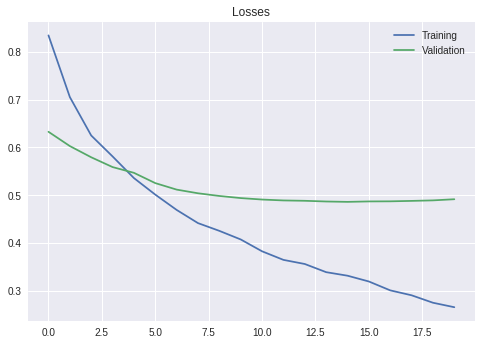

In [44]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

## Task B

In [19]:
#Create fields
BATCH_SIZE = 128


TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a', LABEL),
               ('subtask_b',LABEL)
              ]

train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=lambda d: d.subtask_a == 'OFF')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_b)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 3520
Validation size: 880
defaultdict(<function _default_unk_index at 0x7f11cf91ebf8>, {'TIN': 0, 'UNT': 1})


In [34]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 100
dropout = 0.5

model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()


t_losses, v_losses = train_helper('subtask_b', model, optimizer, loss_fn = loss_fn, epochs = 20)

Epoch: 0
Iteration 0, loss = 0.8386

Validation Accuracy:
Got 768 / 880 correct (87.27)
TP = 768, FN = 0, TN = 0, FN = 112
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       768
           1       0.00      0.00      0.00       112

   micro avg       0.87      0.87      0.87       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.76      0.87      0.81       880


Epoch: 1
Iteration 0, loss = 0.3424


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Validation Accuracy:
Got 768 / 880 correct (87.27)
TP = 768, FN = 0, TN = 0, FN = 112
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       768
           1       0.00      0.00      0.00       112

   micro avg       0.87      0.87      0.87       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.76      0.87      0.81       880


Epoch: 2
Iteration 0, loss = 0.5065

Validation Accuracy:
Got 768 / 880 correct (87.27)
TP = 768, FN = 0, TN = 0, FN = 112
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       768
           1       0.00      0.00      0.00       112

   micro avg       0.87      0.87      0.87       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.76      0.87      0.81       880


Epoch: 3
Iteration 0, loss = 0.5289

Validation Accuracy:
Got 768 / 880 correct (87.27)
TP = 768, FN = 0, TN = 0, FN = 112
           

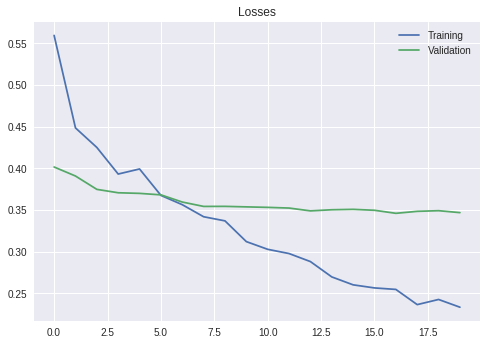

In [35]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()